## Supervised Learning Final Project: Modelling Insurance Costs

**The problem**: A fictional insurance company, Mass Insurance, needs a way to calculate what they should charge their clients based on client-specific factors (e.g. is the client a smoker?)

**The solution**: We will train and refine a multivariate OLS (ordinary least squares) regression model for this exact purpose, such that Mass Insurance can input determining factors into the model and the model will return the amount that they should charge their new client.

### The data
Our data is a public dataset that was sourced from Kaggle (see citation below) and downloaded as a CSV. It consists of over a thousand records that represent insured individuals, including what their (presumably annual) insurance charges are and as well as various health factors, such as if the individual is a smoker, their age, etc.

*APA Citation*: Jain, Simran. (2020). Insurance Premium Data. [Data set]. Kaggle. https://www.kaggle.com/datasets/simranjain17/insurance

 <u>**Data breakdown**</u> 
 
 **Number of records**: 1338
 
 **Number of columns**: 7
 
 **Dependent variable**
- **Charges**: *float* - The amount that the insured pays for insurance (presumably annual)
        
 **Independent variables**
- **Age**: *integer* - The age of the insured
- **Sex**: *category (male, female)* - The sex of the insured
- **BMI**: *integer* - The BMI (body mass index) of the insured
- **Children**: *integer* - The number of children of the insured
- **Smoker**: *category (yes, no)* - Whether the insured is a smoker
- **Region**: *category (southwest, southeast, northwest, northeast)* - The region where the insured lives
        

In [851]:
from sklearn.metrics import mean_absolute_error
import pandas as pd
import sklearn.model_selection
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('insurance.csv')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   float64
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(4), object(3)
memory usage: 73.4+ KB
None


**Data cleaning pt 1**

Drop empty row at end

In [852]:
# drop NaN rows (CSV has at least one empty row)
data = data.dropna(how='any')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   float64
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(4), object(3)
memory usage: 83.6+ KB
None


**Data cleaning pt 1.5**

Checking for outliers, make sure distribution looks correct.

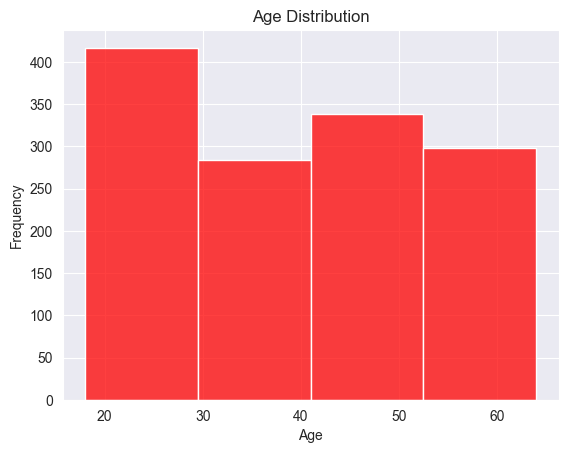

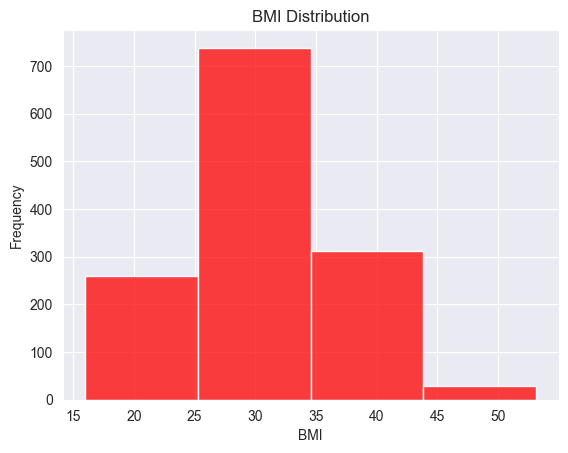

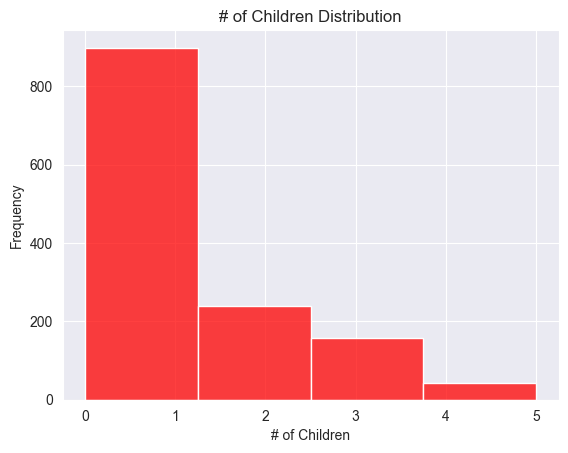

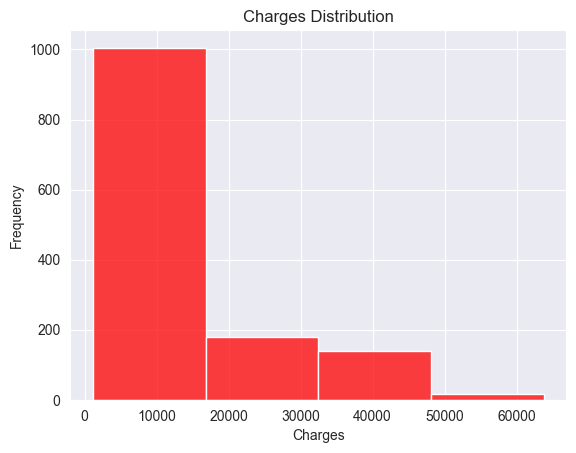

In [853]:
sns.histplot(data['age'], bins=4, kde=False, color='red')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data['bmi'], bins=4, kde=False, color='red')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data['children'], bins=4, kde=False, color='red')
plt.title('# of Children Distribution')
plt.xlabel('# of Children')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data['charges'], bins=4, kde=False, color='red')
plt.title('Charges Distribution')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

**Data cleaning conclusions**

Really, this dataset is already very clean.

**Initial EDA**

Age and BMI have some correlation to charges, but not a ton.

Axes(0.125,0.11;0.62x0.77)


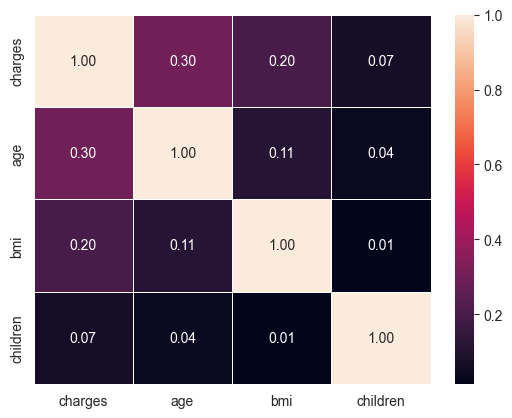

In [854]:
cols = ['charges'] + [col for col in data if col != 'charges']
data = data[cols]

prelim_eda_data = data.select_dtypes(include=['int64', 'float64'])


corr = prelim_eda_data.corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5)
print(heatmap)

**Models: feature engineering pt 1**
 
We have some categorical features that need to be encoded properly if they are to be used in our regression model.

The first, and easiest to encode is the feature that describes whether the insured is a smoker.

In [855]:
# convert smoker to binary
smoker_map = {'yes': 1, 'no': 0}
data['smoker'] = data['smoker'].apply(lambda x: smoker_map[x])

**Models: feature engineering pt 2**

Next, we have a couple of categorical features (`sex` and `region`) which are slightly harder to encode as they are not ordinal categorical variables and
thus cannot be encoded into integers.

However, we can easily one-hot encode both of these features using the pandas `get_dummies` method.


In [856]:
# one-hot encoding for categorical variables
data = pd.get_dummies(data, columns=['sex', 'region'], dtype='int')

# looking at data, all features can be analyzed now
print(data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   charges           1338 non-null   float64
 1   age               1338 non-null   float64
 2   bmi               1338 non-null   float64
 3   children          1338 non-null   float64
 4   smoker            1338 non-null   int64  
 5   sex_female        1338 non-null   int64  
 6   sex_male          1338 non-null   int64  
 7   region_northeast  1338 non-null   int64  
 8   region_northwest  1338 non-null   int64  
 9   region_southeast  1338 non-null   int64  
 10  region_southwest  1338 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 125.4 KB
None


**EDA revisited**

Next, we do some revisited EDA with our new encoded features.

Axes(0.125,0.11;0.62x0.77)


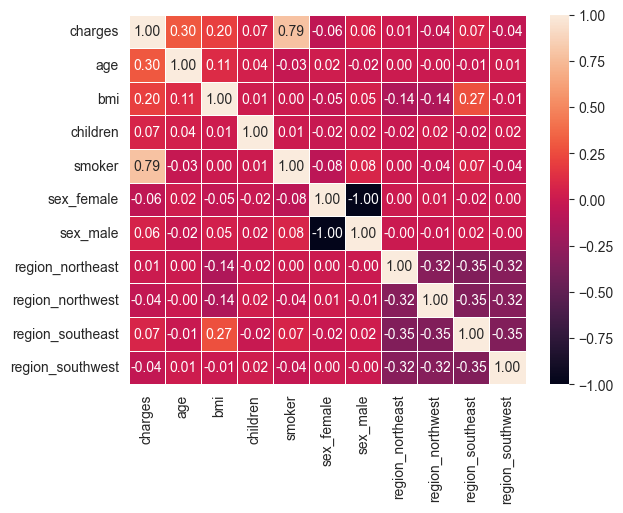

In [857]:

corr = data.corr(method='pearson')

heatmap = sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5)

print(heatmap)

**Models: feature engineering pt 3**

As you can see, previously we used one-hot encoding to convert our categorical features.

For our feature selection, we are going to drop all features except for `smoker`, `age`, and `bmi` since these were the features with the highest correlation with `charges`.

In [858]:
data = data[['charges', 'smoker', 'age', 'bmi']]

**Models: multi-linear regression/collinearity**

Now that our top three features are selected, we can see that these features do not display collinearity as each feature's correlation with each other is quite low, as is evidenced by our simplified correlation heatmap.


Axes(0.125,0.11;0.62x0.77)


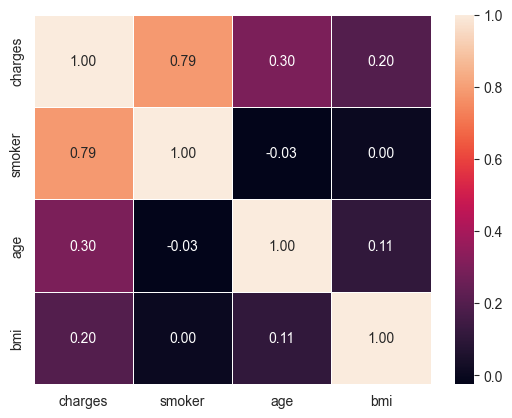

In [859]:
corr = data.corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5)
print(heatmap)

**Models: multiple ML models pt 1**

For our problem, a regression model seems most appropriate, since we are trying to determine what to charge the insured and not whether they should be covered, or some other binary classification.

Using our useful features we generate some models...



In [860]:
X_train, X_test = sklearn.model_selection.train_test_split(data, test_size=0.2)

useful_features = ['smoker','age','bmi']

models = []

formula = 'charges~'

for feature in useful_features:
    formula = f'{formula}+{feature}'
    model = smf.ols(formula=formula, data=X_train).fit()
    models.append(model)
    
for model in models:
    print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     1680.
Date:                Fri, 24 May 2024   Prob (F-statistic):          2.08e-221
Time:                        08:43:42   Log-Likelihood:                -11064.
No. Observations:                1070   AIC:                         2.213e+04
Df Residuals:                    1068   BIC:                         2.214e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8620.9564    256.159     33.655      0.0

**Models - multiple models pt 2**

Here, we see if using polynomials will help.

0.7481131503319278
0.7485845944730608
0.7510513157677335
0.7512500494867906
0.7520176055953365
0.7521819865153353
0.7521055873072449
0.11673112529136509


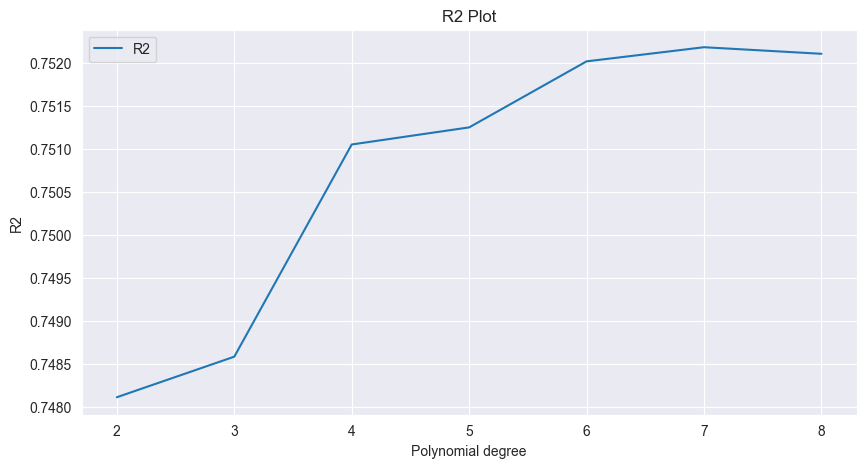

In [861]:
poly_models = []

formula = 'charges~smoker+age+bmi'

powers = []

for i in range(2,10):
    powers.append(i)
    formula = f'{formula}+np.power(smoker,{i})+np.power(age,{i})+np.power(bmi,{i})'
    poly_model = smf.ols(formula=formula, data=X_train).fit()
    print(poly_model.rsquared)
    poly_models.append(poly_model)
    
poly_models = poly_models[:-1]
powers = powers[:-1]
r2s = [model.rsquared for model in poly_models]

data = pd.Series(r2s)
df = pd.DataFrame({'X': powers, 'R2': data})
df.plot(x='X', y='R2', figsize=(10, 5), title='R2 Plot', legend=True, grid=True, label='R2')
plt.xlabel('Polynomial degree')
plt.ylabel('R2')


plt.show()


**Results analysis**

Here, we analyze our results from each model - first, the multi-linear.

MSE 37304570.45299957
R2 0.7593107801009061
MAE 4121.1154011958415
Mean charges: 13130.705907123138


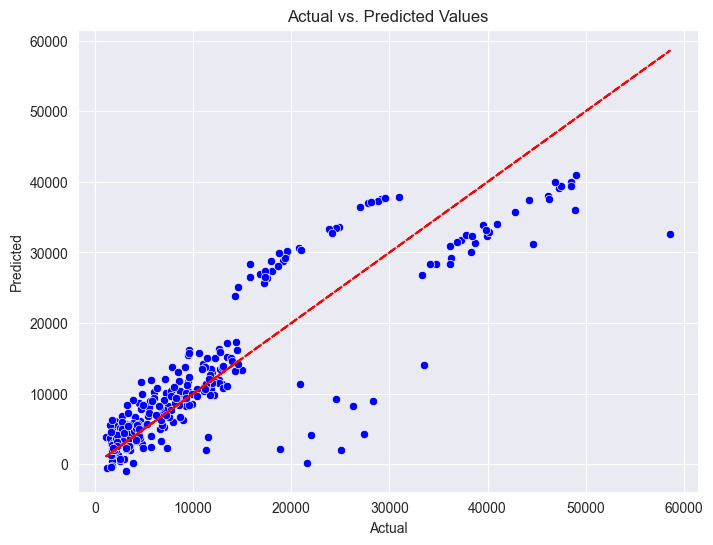

In [862]:

from sklearn.metrics import mean_squared_error, r2_score

y_pred = models[2].predict(X_test)
y_test = X_test['charges']

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE {mse}')
print(f'R2 {r2}')
print(f'MAE {mae}')

mean_charges = sum(y_test) / len(y_test)
print(f'Mean charges: {mean_charges}')

# results plot
data = pd.DataFrame({    'Actual': y_test,    'Predicted': y_pred})
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=data, marker='o', color='blue')
plt.plot(data['Actual'], data['Actual'], 'r--')  # Red dashed line for perfect prediction
plt.title('Actual vs. Predicted Values')
plt.show()






Next, the multivariate polynomial...

MAE 4244.619404981111
MAE 4221.407522204696
MAE 4287.456964223317
MAE 4274.950632351379
MAE 4274.894623162326
MAE 4269.713694374819
MAE 4280.302156866691


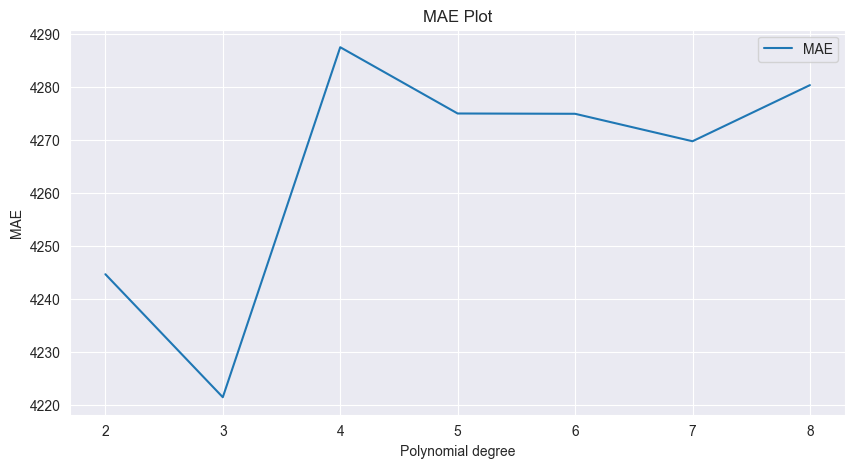

In [863]:

from sklearn.metrics import mean_squared_error, r2_score

maes = []

for poly in poly_models:

    y_pred = poly.predict(X_test)
    y_test = X_test['charges']
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    maes.append(mae)
    
    print(f'MAE {mae}')

data = pd.Series(maes)
df = pd.DataFrame({'X': powers, 'R2': maes})
df.plot(x='X', y='R2', figsize=(10, 5), title='MAE Plot', legend=True, grid=True, label='MAE')
plt.xlabel('Polynomial degree')
plt.ylabel('MAE')
plt.show()


**Conclusions**

*Learning and Takeaways:*

I found it interesting that a binary feature, `smoker`, had such a high correlation with `charges`.  Of course it makes sense - being a smoker is highly detrimental to health and premiums are typically higher for smokers, but it's not the feature that I expected to have the highest correlation.

*Something that Didn't Work:*

Our polynomial models were a slight failure.  They had higher R2 values, but their MAEs were also higher indicating that they may have been overfit.

*Ways to Improve:*

Possibly experimenting more with polynomial or weighted models, or other more complex models in general to achieve a better fit.  This multivariate model was a fairly simple one.